<h1> Parameter Tuning
    
    Look for better optimizer

# Importing libraries:

In [6]:
!pip install pandas
!pip install sklearn

import pandas as pd;
import numpy as np;
import sklearn

# Import data; set X and y; fill nan values and split in test and training  data:

In [7]:
# import data
data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

# for later use
features_num = 15

# 2018 data
data = data.loc[data.index > 2018070000, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# fill nan values
data.fillna(method = 'ffill', inplace = True)

from sklearn.model_selection import train_test_split

# divide data into train and test 
data_train, data_test = train_test_split(
         data, test_size = 0.15, shuffle=False)

# Apply feature scaling:

In [8]:
from sklearn.preprocessing import MinMaxScaler

# data scaling  (including offer (y))
sc_X = MinMaxScaler()
data_train = sc_X.fit_transform(data_train)
data_test = sc_X.transform(data_test)

# Importing the Keras libraries and packages:

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras import optimizers
from keras.callbacks import EarlyStopping

mae_gen = []
rmse_gen = []
mae_nor = []
mae_spi = []
rmse_nor = []
rmse_spi = []
hist_list = []
y_pred_list = []
prediction_list = []
time_count = []

# Prepare of data according to LSTM needs,  create regressor & tune:

In [10]:
# parameters
steps = 96
n_hidden = 1
units = 150
batch_size = 96

# parameters
optimizers = [optimizers.RMSprop(), 
              optimizers.Adam(), 
              optimizers.Nadam(),
              optimizers.Adamax()]


# function to split data into correct shape for RNN
def split_data(X, y, steps):
    X_, y_ = list(), list()
    for i in range(steps, len(y)):
        X_.append(X[i - steps : i, :])
        y_.append(y[i]) 
    return np.array(X_), np.array(y_)

# function to cut data set so it can be divisible by the batch_size
def cut_data(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

# divide features and labels
X_train = data_train[:, 0:15] 
y_train = data_train[:, -1]
X_test = data_test[:, 0:15] 
y_test = data_test[:, -1] 

# divide data into train and test 
X_train, X_val, y_train, y_val = train_test_split(
         X_train, y_train, test_size = 0.15, shuffle=False)

# put data into correct shape
X_train, y_train = split_data(X_train, y_train, steps)
X_test, y_test = split_data(X_test, y_test, steps)
X_val, y_val = split_data(X_val, y_val, steps)

X_train = cut_data(X_train, batch_size)
y_train = cut_data(y_train, batch_size)
X_test = cut_data(X_test, batch_size)
y_test = cut_data(y_test, batch_size)
X_val = cut_data(X_val, batch_size)
y_val = cut_data(y_val, batch_size)

# inverse of test set should not be inside the loop 
y_test = (y_test * sc_X.data_range_[15]) + (sc_X.data_min_[15])

for i in optimizers:
    
    # design the LSTM
    def regressor_tunning(kernel_initializer = 'he_normal',
                      bias_initializer = initializers.Ones()):

        model = Sequential()

        if n_hidden == 0:
            model.add(LSTM(units = units,                    
                           batch_input_shape = (batch_size, steps, features_num), 
                           stateful = True,
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
        else:
            model.add(LSTM(units = units,                    
                           batch_input_shape = (batch_size, steps, features_num), 
                           stateful = True,
                           return_sequences = True,
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
            model.add(LSTM(units = units, 
                           batch_input_shape = (batch_size, steps, features_num), 
                           stateful = True,
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
        model.add(Dense(1, activation='linear'))
        optimizer = i
        model.compile(loss = 'mse', metrics = ['mse', 'mae'], optimizer = optimizer)
        return model

    model = regressor_tunning()

    # fitting the LSTM to the training set
    history = model.fit(X_train,
                        y_train, 
                        batch_size = batch_size, 
                        epochs = 180,
                        shuffle = False, 
                        validation_data = (X_val, y_val))
    
    model.reset_states()
    
    # make new predicitons with test set
    y_pred = model.predict(X_test, batch_size = batch_size)
    
    # prices col = 15
    y_pred = (y_pred * sc_X.data_range_[15]) + (sc_X.data_min_[15])

    y_pred_list.append(y_pred)
    
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mae_error = mae(y_test, y_pred)
    
    rmse_gen.append(rmse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values
    
    # smal adjustment
    y_test = pd.Series(y_test)
    y_test.replace(0, 0.0001,inplace = True)

    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mae_nor.append(mae_normal)

Epoch 1/180
65/65 [==============================] - 32s 491ms/step - loss: 0.3554 - mse: 0.3554 - mae: 0.3783 - val_loss: 0.0508 - val_mse: 0.0508 - val_mae: 0.2232
Epoch 2/180
65/65 [==============================] - 31s 472ms/step - loss: 0.0693 - mse: 0.0693 - mae: 0.2092 - val_loss: 0.0322 - val_mse: 0.0322 - val_mae: 0.1763
Epoch 3/180
65/65 [==============================] - 32s 494ms/step - loss: 0.0240 - mse: 0.0240 - mae: 0.1226 - val_loss: 0.0118 - val_mse: 0.0118 - val_mae: 0.1032
Epoch 4/180
65/65 [==============================] - 32s 496ms/step - loss: 0.0085 - mse: 0.0085 - mae: 0.0721 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0618
Epoch 5/180
65/65 [==============================] - 32s 487ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0457 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0164
Epoch 6/180
65/65 [==============================] - 30s 464ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0326 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0216
Epoc

65/65 [==============================] - 26s 394ms/step - loss: 9.1067e-04 - mse: 9.1067e-04 - mae: 0.0177 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0186
Epoch 49/180
65/65 [==============================] - 26s 398ms/step - loss: 9.0873e-04 - mse: 9.0873e-04 - mae: 0.0176 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0185
Epoch 50/180
65/65 [==============================] - 27s 415ms/step - loss: 9.0745e-04 - mse: 9.0745e-04 - mae: 0.0176 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0185
Epoch 51/180
65/65 [==============================] - 26s 393ms/step - loss: 9.0430e-04 - mse: 9.0430e-04 - mae: 0.0176 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0184
Epoch 52/180
65/65 [==============================] - 27s 409ms/step - loss: 9.0560e-04 - mse: 9.0560e-04 - mae: 0.0176 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0183
Epoch 53/180
65/65 [==============================] - 26s 400ms/step - loss: 9.0807e-04 - mse: 9.0807e-04 - mae: 0.0176 - val_loss: 0.0011

Epoch 95/180
65/65 [==============================] - 30s 462ms/step - loss: 8.9948e-04 - mse: 8.9948e-04 - mae: 0.0175 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0179
Epoch 96/180
65/65 [==============================] - 29s 449ms/step - loss: 8.9680e-04 - mse: 8.9680e-04 - mae: 0.0175 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0181
Epoch 97/180
65/65 [==============================] - 30s 458ms/step - loss: 8.9898e-04 - mse: 8.9898e-04 - mae: 0.0175 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0179
Epoch 98/180
65/65 [==============================] - 28s 427ms/step - loss: 8.9826e-04 - mse: 8.9826e-04 - mae: 0.0175 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0180
Epoch 99/180
65/65 [==============================] - 30s 460ms/step - loss: 8.9886e-04 - mse: 8.9886e-04 - mae: 0.0175 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0176
Epoch 100/180
65/65 [==============================] - 29s 453ms/step - loss: 9.0211e-04 - mse: 9.0211e-04 - mae: 0.0176 - va

65/65 [==============================] - 37s 568ms/step - loss: 8.8739e-04 - mse: 8.8739e-04 - mae: 0.0173 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0174
Epoch 142/180
65/65 [==============================] - 39s 596ms/step - loss: 8.8670e-04 - mse: 8.8670e-04 - mae: 0.0173 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0172
Epoch 143/180
65/65 [==============================] - 38s 581ms/step - loss: 8.8721e-04 - mse: 8.8721e-04 - mae: 0.0172 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0171
Epoch 144/180
65/65 [==============================] - 37s 565ms/step - loss: 8.8444e-04 - mse: 8.8444e-04 - mae: 0.0172 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0169
Epoch 145/180
65/65 [==============================] - 39s 603ms/step - loss: 8.8632e-04 - mse: 8.8632e-04 - mae: 0.0172 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0172
Epoch 146/180
65/65 [==============================] - 38s 580ms/step - loss: 8.8706e-04 - mse: 8.8706e-04 - mae: 0.0173 - val_loss: 0

65/65 [==============================] - 34s 525ms/step - loss: 0.0048 - mse: 0.0048 - mae: 0.0536 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0176
Epoch 8/180
65/65 [==============================] - 32s 486ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0477 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0165
Epoch 9/180
65/65 [==============================] - 29s 453ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0428 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0245
Epoch 10/180
65/65 [==============================] - 29s 439ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0395 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0256
Epoch 11/180
65/65 [==============================] - 30s 462ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0359 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0228
Epoch 12/180
65/65 [==============================] - 34s 525ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0334 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0240
Epoch 13/180


65/65 [==============================] - 27s 408ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0198 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0197
Epoch 57/180
65/65 [==============================] - 26s 393ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0194 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0204
Epoch 58/180
65/65 [==============================] - 26s 397ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0194 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0212
Epoch 59/180
65/65 [==============================] - 27s 414ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0191 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0208
Epoch 60/180
65/65 [==============================] - 26s 401ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0191 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0213
Epoch 61/180
65/65 [==============================] - 26s 402ms/step - loss: 9.9535e-04 - mse: 9.9535e-04 - mae: 0.0189 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0210
Epo

65/65 [==============================] - 25s 390ms/step - loss: 9.2242e-04 - mse: 9.2242e-04 - mae: 0.0178 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0186
Epoch 104/180
65/65 [==============================] - 26s 398ms/step - loss: 9.2078e-04 - mse: 9.2078e-04 - mae: 0.0179 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0185
Epoch 105/180
65/65 [==============================] - 26s 393ms/step - loss: 9.1947e-04 - mse: 9.1947e-04 - mae: 0.0178 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0188
Epoch 106/180
65/65 [==============================] - 26s 393ms/step - loss: 9.1645e-04 - mse: 9.1645e-04 - mae: 0.0178 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0186
Epoch 107/180
65/65 [==============================] - 25s 388ms/step - loss: 9.1958e-04 - mse: 9.1958e-04 - mae: 0.0178 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0187
Epoch 108/180
65/65 [==============================] - 25s 390ms/step - loss: 9.1868e-04 - mse: 9.1868e-04 - mae: 0.0179 - val_loss: 0

65/65 [==============================] - 26s 403ms/step - loss: 9.0399e-04 - mse: 9.0399e-04 - mae: 0.0176 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0187
Epoch 150/180
65/65 [==============================] - 26s 406ms/step - loss: 9.0999e-04 - mse: 9.0999e-04 - mae: 0.0177 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0184
Epoch 151/180
65/65 [==============================] - 25s 389ms/step - loss: 8.9567e-04 - mse: 8.9567e-04 - mae: 0.0174 - val_loss: 9.6570e-04 - val_mse: 9.6570e-04 - val_mae: 0.0179
Epoch 152/180
65/65 [==============================] - 26s 405ms/step - loss: 9.0314e-04 - mse: 9.0314e-04 - mae: 0.0175 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0184
Epoch 153/180
65/65 [==============================] - 25s 389ms/step - loss: 8.8970e-04 - mse: 8.8970e-04 - mae: 0.0174 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0184
Epoch 154/180
65/65 [==============================] - 26s 405ms/step - loss: 9.0134e-04 - mse: 9.0134e-04 - mae: 0.0176 - val

Epoch 16/180
65/65 [==============================] - 34s 519ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0223 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0196
Epoch 17/180
65/65 [==============================] - 34s 519ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0217 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0189
Epoch 18/180
65/65 [==============================] - 40s 608ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0216 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0180
Epoch 19/180
65/65 [==============================] - 35s 541ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0210 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0183
Epoch 20/180
65/65 [==============================] - 37s 574ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0209 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0186
Epoch 21/180
65/65 [==============================] - 34s 530ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0202 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.018

65/65 [==============================] - 34s 519ms/step - loss: 9.1746e-04 - mse: 9.1746e-04 - mae: 0.0177 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0168
Epoch 64/180
65/65 [==============================] - 33s 515ms/step - loss: 9.2093e-04 - mse: 9.2093e-04 - mae: 0.0177 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0170
Epoch 65/180
65/65 [==============================] - 36s 555ms/step - loss: 9.1805e-04 - mse: 9.1805e-04 - mae: 0.0177 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0165
Epoch 66/180
65/65 [==============================] - 36s 559ms/step - loss: 9.1297e-04 - mse: 9.1297e-04 - mae: 0.0176 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0170
Epoch 67/180
65/65 [==============================] - 32s 490ms/step - loss: 9.0675e-04 - mse: 9.0675e-04 - mae: 0.0176 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0173
Epoch 68/180
65/65 [==============================] - 36s 558ms/step - loss: 9.1268e-04 - mse: 9.1268e-04 - mae: 0.0177 - val_loss: 0.0011

Epoch 110/180
65/65 [==============================] - 25s 380ms/step - loss: 8.7974e-04 - mse: 8.7974e-04 - mae: 0.0172 - val_loss: 9.6970e-04 - val_mse: 9.6970e-04 - val_mae: 0.0168
Epoch 111/180
65/65 [==============================] - 27s 413ms/step - loss: 8.6853e-04 - mse: 8.6853e-04 - mae: 0.0169 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0167
Epoch 112/180
65/65 [==============================] - 25s 392ms/step - loss: 8.7389e-04 - mse: 8.7389e-04 - mae: 0.0170 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0164
Epoch 113/180
65/65 [==============================] - 26s 403ms/step - loss: 8.6806e-04 - mse: 8.6806e-04 - mae: 0.0169 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0162
Epoch 114/180
65/65 [==============================] - 26s 408ms/step - loss: 8.9395e-04 - mse: 8.9395e-04 - mae: 0.0173 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0168
Epoch 115/180
65/65 [==============================] - 25s 389ms/step - loss: 8.8432e-04 - mse: 8.8432e-04 - mae

65/65 [==============================] - 26s 400ms/step - loss: 8.7230e-04 - mse: 8.7230e-04 - mae: 0.0170 - val_loss: 9.6010e-04 - val_mse: 9.6010e-04 - val_mae: 0.0171
Epoch 157/180
65/65 [==============================] - 28s 425ms/step - loss: 8.6911e-04 - mse: 8.6911e-04 - mae: 0.0169 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0168
Epoch 158/180
65/65 [==============================] - 27s 409ms/step - loss: 8.8003e-04 - mse: 8.8003e-04 - mae: 0.0172 - val_loss: 9.8200e-04 - val_mse: 9.8200e-04 - val_mae: 0.0163
Epoch 159/180
65/65 [==============================] - 27s 409ms/step - loss: 8.6949e-04 - mse: 8.6949e-04 - mae: 0.0170 - val_loss: 9.5106e-04 - val_mse: 9.5106e-04 - val_mae: 0.0180
Epoch 160/180
65/65 [==============================] - 25s 390ms/step - loss: 8.7504e-04 - mse: 8.7504e-04 - mae: 0.0170 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0175
Epoch 161/180
65/65 [==============================] - 26s 400ms/step - loss: 9.0415e-04 - mse: 9.0415e-04 - m

65/65 [==============================] - 28s 438ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0320 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0201
Epoch 24/180
65/65 [==============================] - 29s 441ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0311 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0210
Epoch 25/180
65/65 [==============================] - 27s 418ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0298 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0196
Epoch 26/180
65/65 [==============================] - 27s 414ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0294 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0202
Epoch 27/180
65/65 [==============================] - 27s 415ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0283 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0217
Epoch 28/180
65/65 [==============================] - 35s 533ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0274 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0194
Epoch 29/18

65/65 [==============================] - 42s 650ms/step - loss: 9.6583e-04 - mse: 9.6583e-04 - mae: 0.0183 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0208
Epoch 72/180
65/65 [==============================] - 40s 610ms/step - loss: 9.7034e-04 - mse: 9.7034e-04 - mae: 0.0186 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0200
Epoch 73/180
65/65 [==============================] - 45s 692ms/step - loss: 9.6204e-04 - mse: 9.6204e-04 - mae: 0.0184 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0201
Epoch 74/180
65/65 [==============================] - 40s 622ms/step - loss: 9.6342e-04 - mse: 9.6342e-04 - mae: 0.0184 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0204
Epoch 75/180
65/65 [==============================] - 38s 592ms/step - loss: 9.4926e-04 - mse: 9.4926e-04 - mae: 0.0183 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0204
Epoch 76/180
65/65 [==============================] - 38s 591ms/step - loss: 9.6299e-04 - mse: 9.6299e-04 - mae: 0.0184 - val_loss: 0.0010

65/65 [==============================] - 37s 565ms/step - loss: 8.4998e-04 - mse: 8.4998e-04 - mae: 0.0165 - val_loss: 8.4250e-04 - val_mse: 8.4250e-04 - val_mae: 0.0187
Epoch 117/180
65/65 [==============================] - 38s 586ms/step - loss: 8.4909e-04 - mse: 8.4909e-04 - mae: 0.0165 - val_loss: 8.2757e-04 - val_mse: 8.2757e-04 - val_mae: 0.0183
Epoch 118/180
65/65 [==============================] - 35s 540ms/step - loss: 8.4294e-04 - mse: 8.4294e-04 - mae: 0.0164 - val_loss: 7.9463e-04 - val_mse: 7.9463e-04 - val_mae: 0.0168
Epoch 119/180
65/65 [==============================] - 35s 531ms/step - loss: 8.4077e-04 - mse: 8.4077e-04 - mae: 0.0164 - val_loss: 8.2681e-04 - val_mse: 8.2681e-04 - val_mae: 0.0182
Epoch 120/180
65/65 [==============================] - 37s 568ms/step - loss: 8.3370e-04 - mse: 8.3370e-04 - mae: 0.0164 - val_loss: 8.2829e-04 - val_mse: 8.2829e-04 - val_mae: 0.0183
Epoch 121/180
65/65 [==============================] - 36s 557ms/step - loss: 8.3463e-04 - mse

65/65 [==============================] - 38s 589ms/step - loss: 7.7976e-04 - mse: 7.7976e-04 - mae: 0.0155 - val_loss: 7.8738e-04 - val_mse: 7.8738e-04 - val_mae: 0.0169
Epoch 161/180
65/65 [==============================] - 37s 568ms/step - loss: 7.6738e-04 - mse: 7.6738e-04 - mae: 0.0154 - val_loss: 8.5029e-04 - val_mse: 8.5029e-04 - val_mae: 0.0186
Epoch 162/180
65/65 [==============================] - 35s 543ms/step - loss: 7.7973e-04 - mse: 7.7973e-04 - mae: 0.0158 - val_loss: 8.0622e-04 - val_mse: 8.0622e-04 - val_mae: 0.0161
Epoch 163/180
65/65 [==============================] - 36s 548ms/step - loss: 7.7628e-04 - mse: 7.7628e-04 - mae: 0.0155 - val_loss: 8.3325e-04 - val_mse: 8.3325e-04 - val_mae: 0.0176
Epoch 164/180
65/65 [==============================] - 36s 547ms/step - loss: 7.7457e-04 - mse: 7.7457e-04 - mae: 0.0156 - val_loss: 8.1468e-04 - val_mse: 8.1468e-04 - val_mae: 0.0178
Epoch 165/180
65/65 [==============================] - 35s 543ms/step - loss: 7.5379e-04 - mse

# Save results:

In [11]:
results = pd.DataFrame({'optimizers':optimizers,
                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor})

results.to_csv('Results_LSTM_3_optimizer.csv')

y_pred = pd.DataFrame({'optimizers':optimizers,
                       'Predicitons': y_pred_list})

y_pred.to_csv('Pedictions_LSTM_3_optimizers.csv')

In [16]:
results = pd.DataFrame({'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor})

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0,32.536261,20.998041,29.362422,20.628882,32.981703,21.052881
1,33.268096,23.631728,30.429167,23.274971,33.669416,23.684726
2,33.545703,23.893952,30.897532,23.795983,33.921468,23.908506
3,33.508238,20.099735,27.877429,16.356400,34.265872,20.655824


<IPython.core.display.Javascript object>


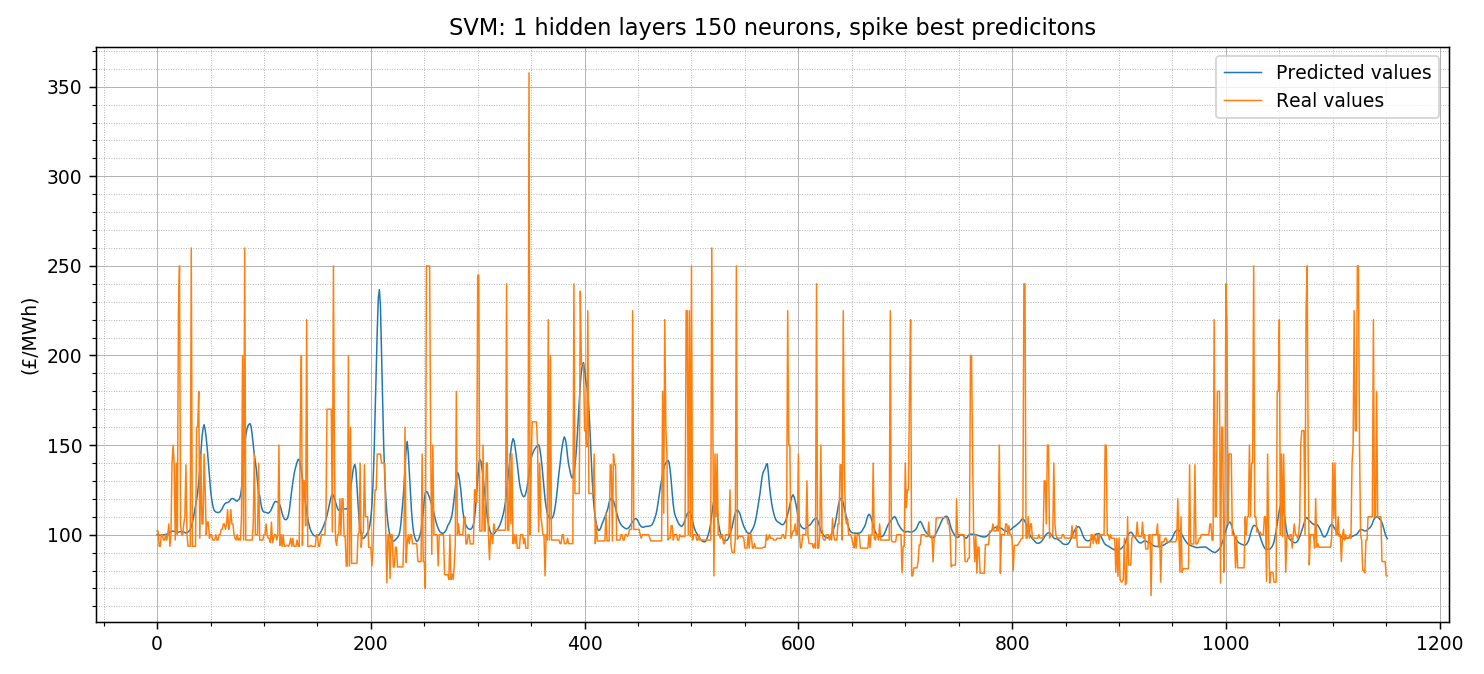

In [14]:
!pip install matplotlib
import matplotlib.pyplot as plt

%matplotlib notebook

predicted = y_pred_list[-1]
plt.figure(figsize=(11,5))
plt.plot(predicted, label = 'Predicted values', linewidth = 0.8)
plt.plot(np.array(y_test), label = 'Real values', linewidth = 0.8)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.ylabel('(£/MWh)')
plt.title('SVM: 1 hidden layers 150 neurons, spike best predicitons')
plt.legend()
plt.tight_layout()